## Assignment 2: Multi-class Classification Example

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

2022-10-19 20:49:41.719033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.4 Example using customer segmentation data 

In [4]:
# import data 
data = pd.read_csv("Life Expectancy Data.csv").dropna()

# data is based on life expectancy for developing countries
# got rid of Country & Status variables (categorical variables that are not necessary)
# output variable (life_expectancy) 
data = data.drop(columns=['Country', 'Status'])

print(data.head()) 

train_data, test_data, train_targets, test_targets = train_test_split(
                            data.drop(columns='Life_Expectancy').values, 
                            data['Life_Expectancy'].values, 
                            test_size=0.3, random_state=514)

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

   Year  Life_Expectancy  Adult Mortality  infant deaths  Alcohol  \
0  2015             65.0            263.0             62     0.01   
1  2014             59.9            271.0             64     0.01   
2  2013             59.9            268.0             66     0.01   
3  2012             59.5            272.0             69     0.01   
4  2011             59.2            275.0             71     0.01   

   percentage expenditure  Hepatitis B  Measles    BMI   under-five deaths   \
0               71.279624         65.0      1154   19.1                  83   
1               73.523582         62.0       492   18.6                  86   
2               73.219243         64.0       430   18.1                  89   
3               78.184215         67.0      2787   17.6                  93   
4                7.097109         68.0      3013   17.2                  97   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16    

In [5]:
print(train_data.shape)
print(test_data.shape)

(1154, 19)
(495, 19)


In [20]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [26]:
# K-fold validation from textbook
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [27]:
all_scores

[2.0536441802978516,
 1.9896727800369263,
 2.7550201416015625,
 2.1872994899749756]

In [28]:
np.mean(all_scores)

2.246409147977829

In [30]:
# saves the per-epoch validation score log 
# (keeps a record of how ell the model does at each epoch)
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [31]:
# average of the per-epoch MAE scores for all folds
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

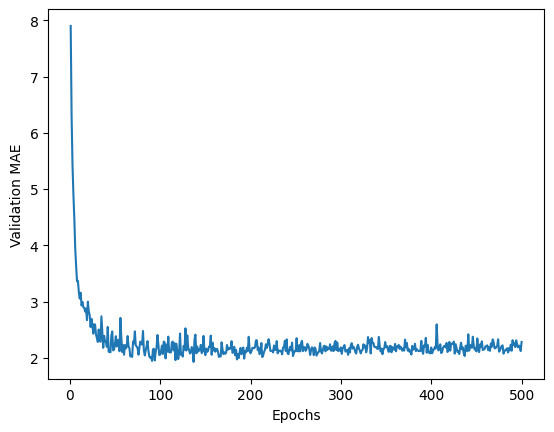

In [32]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

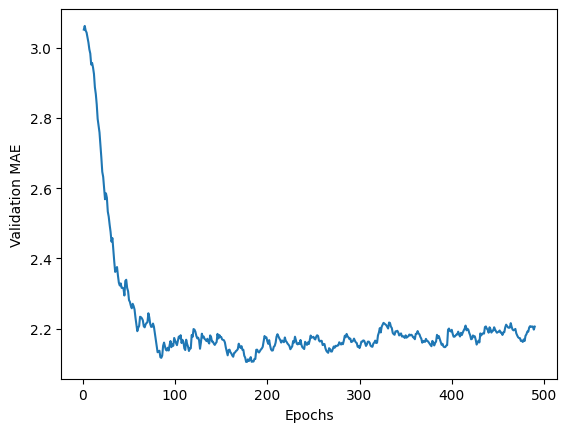

In [41]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [42]:
# final model built with 80 epochs (based on textbook example, so not necessarily the optimal)
model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

16/16 [==============================] - 0s 753us/step - loss: 7.2651 - mae: 1.9981


1.9981423616409302

In [7]:
np.mean(data['Life_Expectancy'])

69.3023044269254